In [67]:
import json
import os
import argparse

import numpy as np
import random
import torch
from torch import nn, optim
from tqdm.auto import tqdm
from transformers import AutoImageProcessor, AutoModelForImageClassification, AutoConfig
from transformers import AutoTokenizer, AutoModelForSequenceClassification

from pathlib import Path
from torch.utils.data import DataLoader, Subset
import sys
sys.path.append('../lib/exlib/src')
# from exlib.modules.sop import SOPImageCls, SOPConfig, get_chained_attr

In [68]:
from sop import SOP

def get_chained_attr(obj, attr_path):
    if attr_path is None:
        return None
    # Split the attribute path into individual attribute names
    attributes = attr_path.split('.')

    # Access the attribute dynamically
    desired_attribute = obj
    for attr in attributes:
        desired_attribute = getattr(desired_attribute, attr)
    return desired_attribute

In [69]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

SEED = 42
if SEED != -1:
    # Torch RNG
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    # Python RNG
    np.random.seed(SEED)
    random.seed(SEED)

In [70]:
# model paths
backbone_model_name = '../pt_models/vit-base-patch16-224-imagenet10cls'
backbone_processor_name = 'google/vit-base-patch16-224'
sop_config_path = '/shared_data0/weiqiuy/explainable_attn/actions/wrapper/configs/imagenet_vit_wrapper_default.json'
# sop_config_path = 'configs/imagenet_m.json'

# data paths
TRAIN_DATA_DIR = '../data/imagenet_m/train'
VAL_DATA_DIR = '../data/imagenet_m/val'

# training args
batch_size = 1
lr = 0.000005
num_epochs = 20
warmup_steps = 2000
mask_batch_size = 64

# experiment args
exp_dir = '/shared_data0/weiqiuy/explainable_attn/exps/imgenet_m_wrapper_psz16_ind/best'

In [71]:
backbone_model = AutoModelForImageClassification.from_pretrained(backbone_model_name)
processor = AutoImageProcessor.from_pretrained(backbone_processor_name)
backbone_config = AutoConfig.from_pretrained(backbone_model_name)

with open(sop_config_path) as input_file:
    wrapper_config = json.load(input_file)
config = backbone_config
config.__dict__.update(wrapper_config)
# config.blackbox_model_name = args.blackbox_model_name
# config.blackbox_processor_name = args.blackbox_processor_name
# config = SOPConfig()
# config.update_from_json(os.path.join(exp_dir, 'config.json'))

In [72]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

def transform(image):
    # Preprocess the image using the ViTImageProcessor
    image = image.convert("RGB")
    inputs = processor(image, return_tensors='pt')
    return inputs['pixel_values'].squeeze(0)

# Load the dataset
train_dataset = ImageFolder(root=TRAIN_DATA_DIR, transform=transform)
val_dataset = ImageFolder(root=VAL_DATA_DIR, transform=transform)

# Use subset for testing purpose
# num_data = 100
# train_dataset = Subset(train_dataset, range(num_data))
# val_dataset = Subset(val_dataset, range(num_data))

# Create a DataLoader to batch and shuffle the data
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [73]:
from collections import namedtuple

WrappedBackboneOutput = namedtuple("WrappedBackboneOutput", 
                                  ["logits",
                                   "pooler_output"])


class WrappedBackboneModel(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    
    def forward(self, inputs):
        outputs = self.model(inputs, output_hidden_states=True)
        return WrappedBackboneOutput(outputs.logits, outputs.hidden_states[-1][:,0])

In [74]:
model = SOP.from_pretrained(exp_dir,
                            config=config, 
                            blackbox_model=backbone_model,
                            model_type='image',
                            projection_layer=None,
                            aggr_type='independent',
                            pooler=False,
                            return_tuple=True)

Some weights of SOP were not initialized from the model checkpoint at /shared_data0/weiqiuy/explainable_attn/exps/imgenet_m_wrapper_psz16_ind/best and are newly initialized: ['projection_up.bias', 'projection_up.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [75]:
model = model.to(device)

In [76]:
model.training

False

In [77]:
batch = next(iter(val_dataloader))
inputs, labels = batch
inputs, labels = inputs.to(device), labels.to(device)

In [78]:
denormed_img = (inputs[0:1] + 1) / 2

In [79]:
with torch.no_grad():
    expln = model(inputs, epoch=model.config.num_heads)

In [80]:
expln._fields

('logits',
 'logits_all',
 'pooler_outputs_all',
 'masks',
 'mask_weights',
 'attributions',
 'attributions_max',
 'attributions_all',
 'flat_masks')

In [83]:
expln.masks.shape, expln.mask_weights.shape, expln.logits.shape

(torch.Size([1, 392, 224, 224]), torch.Size([1, 392, 10]), torch.Size([1, 10]))

In [105]:
pred = torch.argmax(expln.logits, dim=-1)
pred, labels

(tensor([3], device='cuda:0'), tensor([0], device='cuda:0'))

In [126]:
expln.attributions_all[:,label].unsqueeze(1).shape

torch.Size([1, 1, 224, 224])

In [117]:
def compress_single_masks(masks, masks_weights, pred, min_size):
    # num_masks, seq_len = masks.shape
    masks_bool = (masks > 0).int()
    sorted_weights, sorted_indices = torch.sort(masks_weights[:,pred], descending=True)
    sorted_indices = sorted_indices[sorted_weights > 0]

    masks_bool = masks_bool[sorted_indices]  # sorted masks
    
    masks = torch.zeros(*masks_bool.shape[1:]).to(masks.device)
    masks_scores = torch.zeros(*masks_bool.shape[1:], dtype=masks.dtype).to(masks.device)
    count = 1
    for i, mask in enumerate(masks_bool):
        new_mask = mask.bool() ^ (mask.bool() & masks.bool())
        if torch.sum(new_mask) >= min_size:
            masks[new_mask] = count
            # import pdb; pdb.set_trace()
            masks_scores[new_mask] = sorted_weights[i]
            count += 1

    masks = masks - 1
    masks = masks.int()
    masks[masks == -1] = torch.max(masks) + 1

    return masks, masks_scores

def compress_masks(masks, masks_weights, pred, min_size=0):
    new_masks = []
    new_masks_scores = []
    for i in range(len(masks)):
        compressed_mask, compressed_mask_scores = compress_single_masks(masks[i], masks_weights[i], pred[i],
                                                min_size)
        new_masks.append(compressed_mask)
        new_masks_scores.append(compressed_mask_scores)
    return torch.stack(new_masks), torch.stack(new_masks_scores)


def compress_masks_image(masks, masks_weights, pred, min_size=0):
    assert len(masks.shape) == 4 # bsz, num_masks, img_dim_1, img_dim_2 = masks.shape
    return compress_masks(masks, masks_weights, pred, min_size)

In [118]:
gs_mask, gs_mask_scores = compress_masks_image(expln.masks, expln.mask_weights, pred)
gs_attributions = gs_mask_scores.unsqueeze(1)
gs_attributions.shape

torch.Size([1, 1, 224, 224])

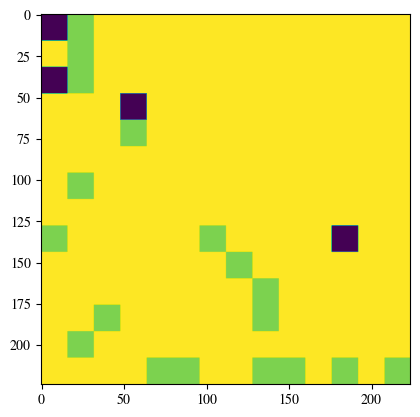

In [119]:
plt.imshow(gs_attributions[0][0].cpu().numpy())

 99%|█████████▉| 223/225 [04:19<00:02,  1.16s/it]


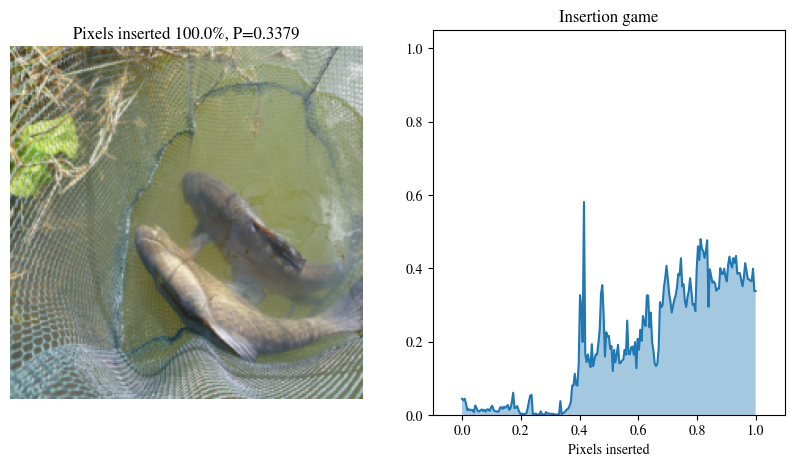

tensor([0.1852], device='cuda:0')

In [121]:
ins_eval_output_cs = ins_evaluator(inputs, cs_attributions, return_dict=True)
ins_evaluator.plot(denormed_img[0], ins_eval_output_cs['scores'][0])
ins_eval_output_cs['auc_score']

In [84]:
cs_attributions =  (expln.masks.unsqueeze(2) * expln.mask_weights.unsqueeze(-1).unsqueeze(-1) * expln.logits.unsqueeze(1).unsqueeze(-1).unsqueeze(-1)).sum(1)[:,pred].unsqueeze(1)
cs_attributions.shape

torch.Size([1, 1, 224, 224])

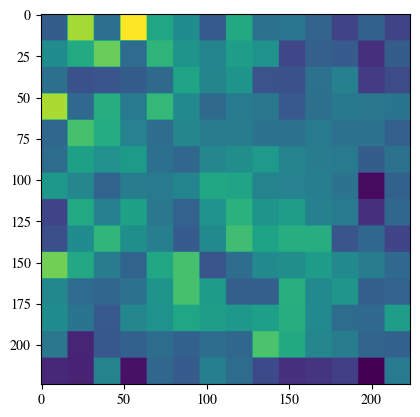

In [85]:
plt.imshow(cs_attributions[0][0].cpu().numpy())

In [86]:
from exlib.evaluators.ins_del import InsertionCls, DeletionCls

In [87]:
class WrappedSOPModel(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    
    def forward(self, inputs):
        outputs = self.model(inputs, epoch=self.model.config.num_heads)
        return outputs.logits

In [89]:
wrapped_sop_model = WrappedSOPModel(model)
del_evaluator = DeletionCls(wrapped_sop_model)
with torch.no_grad():
    del_eval_output_cs = del_evaluator(inputs, cs_attributions, return_dict=True)
del_scores_cs = del_eval_output_cs['scores']


 99%|█████████▉| 223/225 [04:19<00:02,  1.16s/it]


NameError: name 'del_evaluator_cs' is not defined

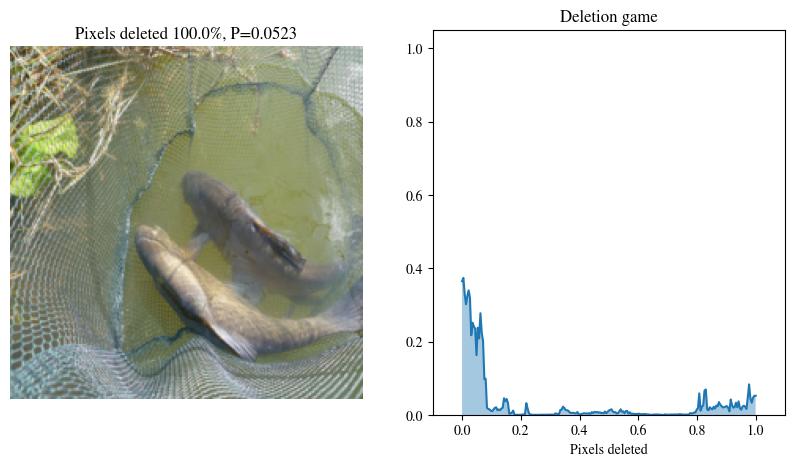

In [91]:
del_evaluator.plot(denormed_img[0], del_scores_cs[0])

In [92]:
del_eval_output_cs['auc_score']

tensor([0.0310], device='cuda:0')

 99%|█████████▉| 223/225 [04:20<00:02,  1.17s/it]


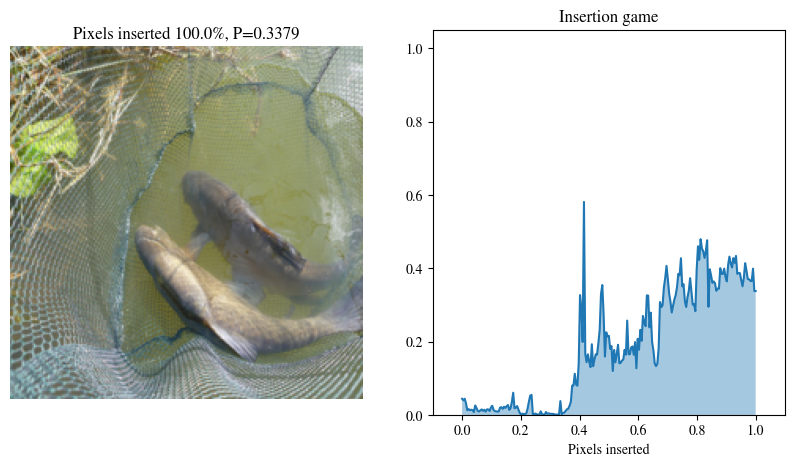

tensor([0.1852], device='cuda:0')

In [93]:
ins_evaluator = InsertionCls(wrapped_sop_model)
ins_eval_output_cs = ins_evaluator(inputs, cs_attributions, return_dict=True)
ins_evaluator.plot(denormed_img[0], ins_eval_output_cs['scores'][0])
ins_eval_output_cs['auc_score']

In [88]:
bool_attributions = ((expln.masks > 0).float().unsqueeze(2) * expln.mask_weights.unsqueeze(-1).unsqueeze(-1)).sum(1)[:,pred].unsqueeze(1)
bool_attributions.shape

torch.Size([1, 1, 224, 224])

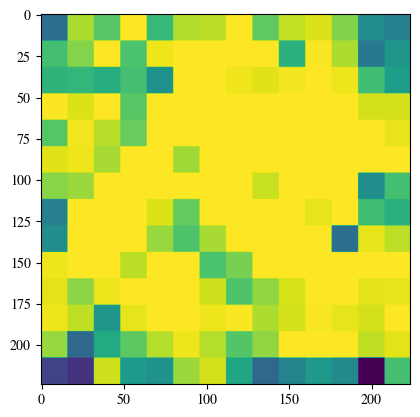

In [66]:
plt.imshow(bool_attributions[0][0].cpu().numpy())

In [16]:
expln.attributions.shape

torch.Size([1, 1, 224, 224])

 99%|█████████▉| 223/225 [04:20<00:02,  1.17s/it]


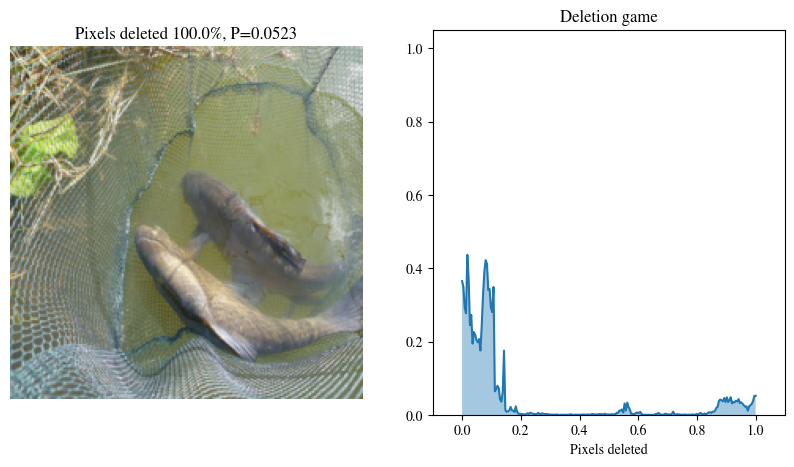

In [62]:
wrapped_sop_model = WrappedSOPModel(model)
del_evaluator = DeletionCls(wrapped_sop_model)
with torch.no_grad():
    del_eval_output = del_evaluator(inputs, bool_attributions, return_dict=True)
del_scores = del_eval_output['scores']
del_evaluator.plot(denormed_img[0], del_scores[0])

In [63]:
del_eval_output['auc_score']

tensor([0.0425], device='cuda:0')

 99%|█████████▉| 223/225 [04:20<00:02,  1.17s/it]


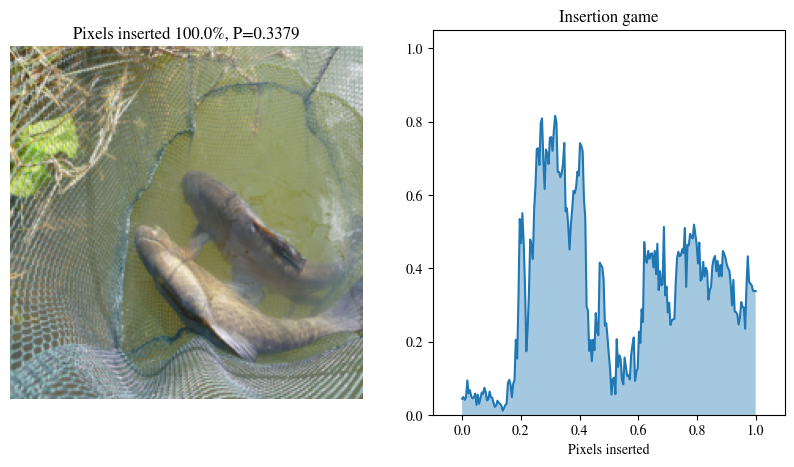

tensor([0.3357], device='cuda:0')

In [64]:
ins_evaluator = InsertionCls(wrapped_sop_model)
ins_eval_output = ins_evaluator(inputs, bool_attributions, return_dict=True)
ins_evaluator.plot(denormed_img[0], ins_eval_output['scores'][0])
ins_eval_output['auc_score']

In [21]:
wrapped_sop_model = WrappedSOPModel(model)
del_evaluator = DeletionCls(wrapped_sop_model)
with torch.no_grad():
    del_score = del_evaluator(inputs, expln.attributions)
inputs.shape, labels.shape, del_score

 99%|█████████▉| 223/225 [04:39<00:02,  1.25s/it]


(torch.Size([1, 3, 224, 224]),
 torch.Size([1]),
 tensor([0.0311], device='cuda:0'))

 99%|█████████▉| 223/225 [04:39<00:02,  1.25s/it]


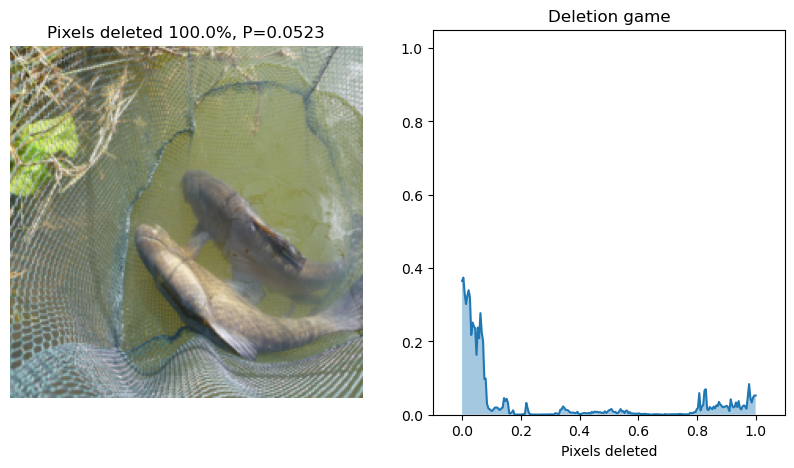

In [22]:
with torch.no_grad():
    del_eval_output = del_evaluator(inputs, expln.attributions, return_dict=True)
del_scores = del_eval_output['scores']
del_evaluator.plot(denormed_img[0], del_scores[0])

 99%|█████████▉| 223/225 [04:40<00:02,  1.26s/it]


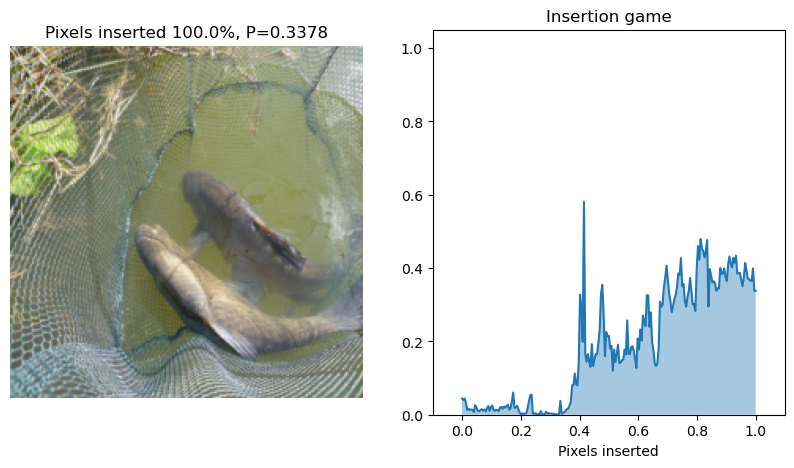

In [24]:
ins_evaluator = InsertionCls(wrapped_sop_model)
ins_eval_output = ins_evaluator(inputs, expln.attributions, return_dict=True)
ins_evaluator.plot(denormed_img[0], ins_eval_output['scores'][0])

In [25]:
ins_eval_output['auc_score']

tensor([0.1851], device='cuda:0')

 99%|█████████▉| 223/225 [00:01<00:00, 172.03it/s]


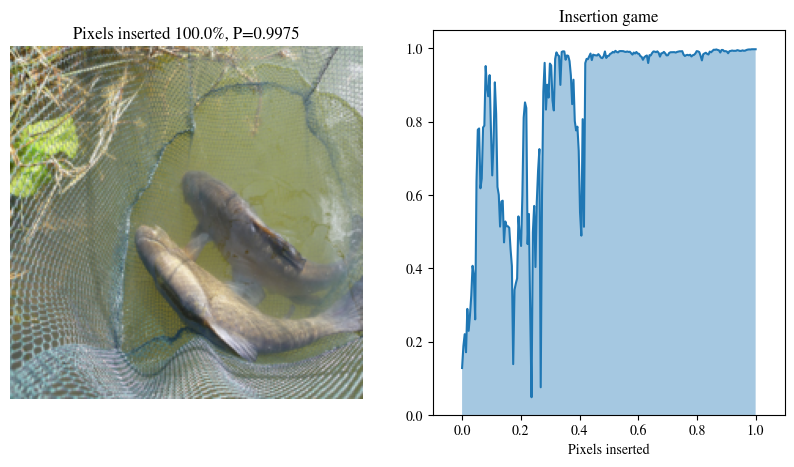

tensor([0.8463], device='cuda:0')

In [97]:
# ins_evaluator = InsertionCls(wrapped_backbone_model_raw)
ins_eval_output = ins_evaluator_bbm(inputs, expln.attributions, return_dict=True)
ins_evaluator.plot(denormed_img[0], ins_eval_output['scores'][0])
ins_eval_output['auc_score']

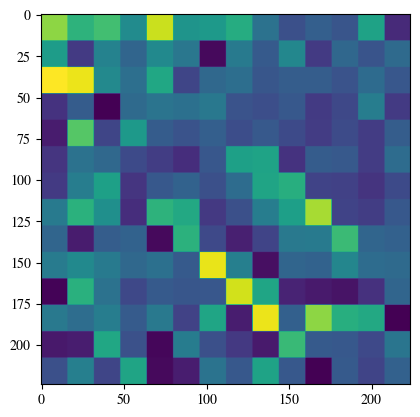

In [77]:
plt.imshow(expln.attributions[0][0].cpu().numpy())

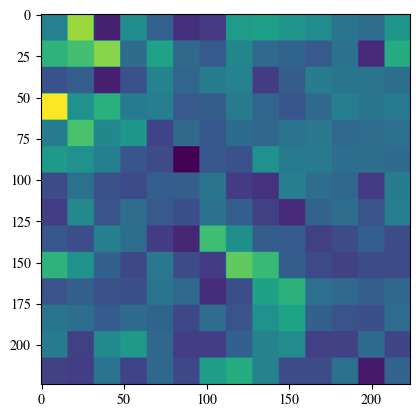

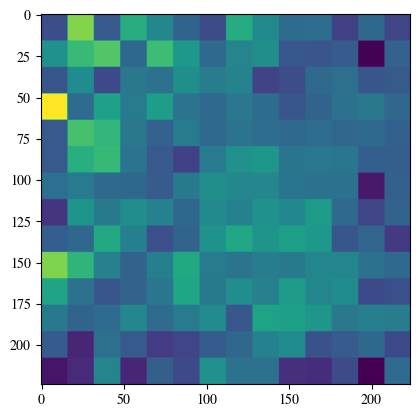

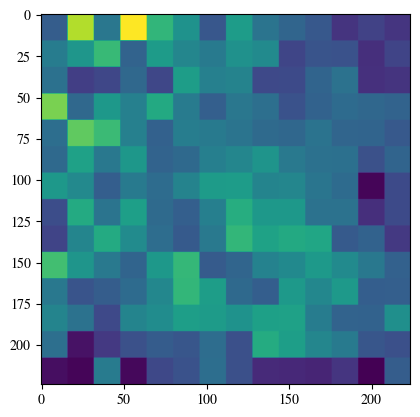

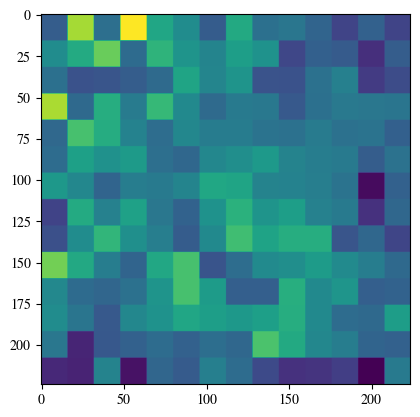

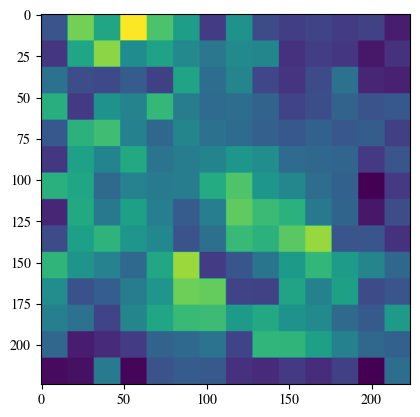

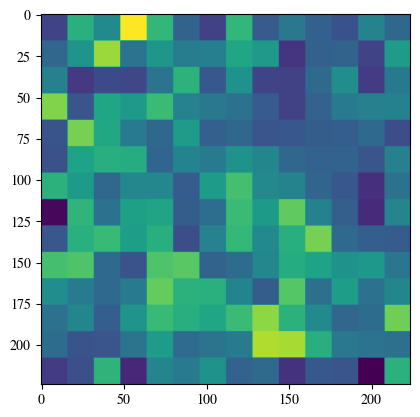

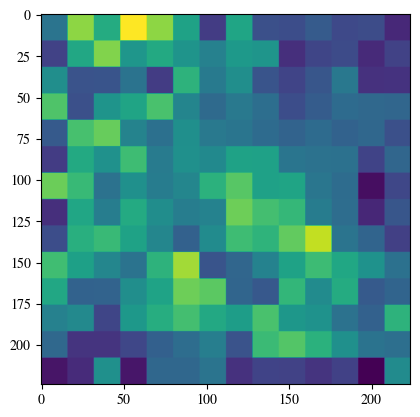

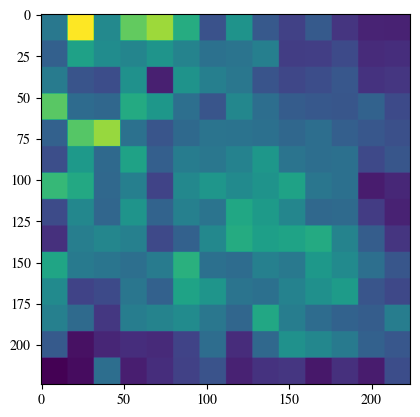

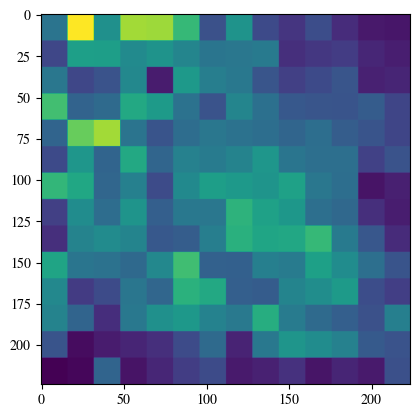

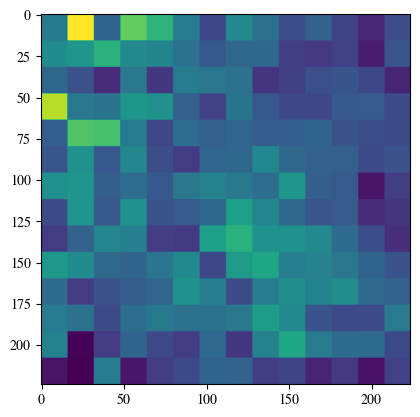

In [60]:
for i in range(expln.attributions_all.shape[1]):
    plt.figure()
    plt.imshow(expln.attributions_all[0][i].cpu().numpy())
    plt.show()

In [26]:
from exlib.evaluators.ins_del import GroupedInsertionCls, GroupedDeletionCls

In [27]:
gdel_evaluator = GroupedDeletionCls(wrapped_sop_model)
with torch.no_grad():
    gdel_score = gdel_evaluator(inputs, expln.attributions, expln.flat_masks)
print(gdel_score)

tensor([0.1045], device='cuda:0')


In [28]:
with torch.no_grad():
    gdel_eval_output = gdel_evaluator(inputs, expln.attributions[0], expln.flat_masks, return_dict=True)

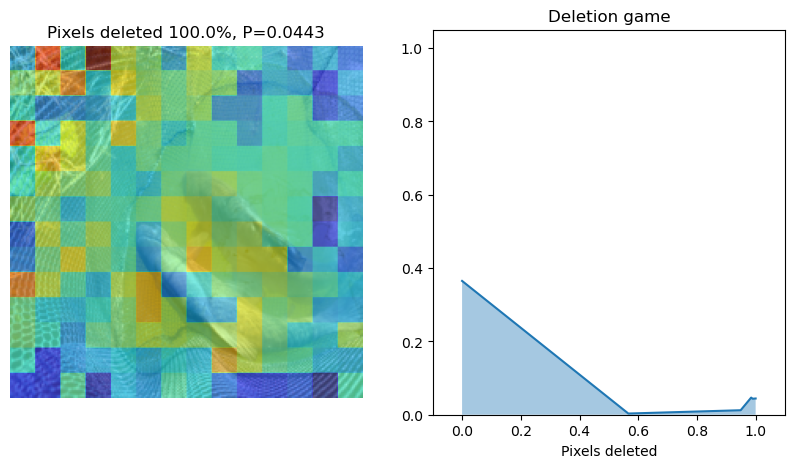

In [29]:
gdel_evaluator.plot(denormed_img[0], expln.attributions[0], gdel_eval_output['scores'][0], gdel_eval_output['step_sizes'][0])

In [30]:
gins_evaluator = GroupedInsertionCls(wrapped_sop_model)
with torch.no_grad():
    gins_score = gins_evaluator(inputs, expln.attributions, expln.flat_masks)
print(gins_score)

tensor([0.1203], device='cuda:0')


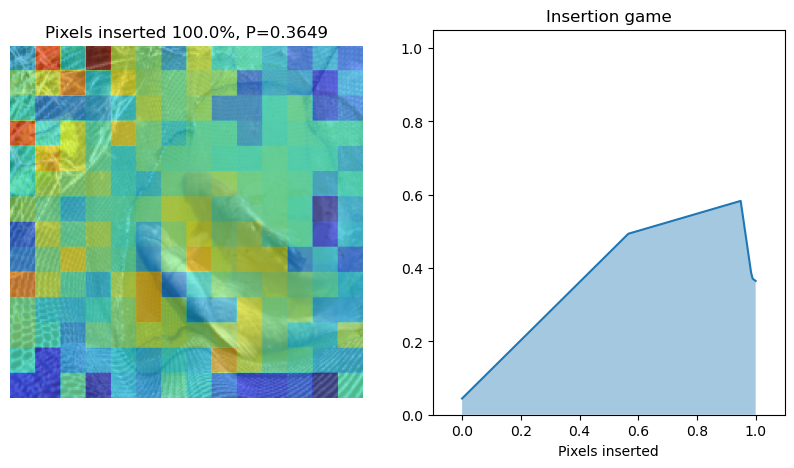

In [31]:
with torch.no_grad():
    gins_eval_output = gins_evaluator(inputs, expln.attributions, expln.flat_masks, return_dict=True)
gins_evaluator.plot(denormed_img[0], expln.attributions[0], gins_eval_output['scores'][0], gins_eval_output['step_sizes'][0])

In [20]:
gins_eval_output['scores']

[tensor([0.1338, 0.9046, 0.8982, 0.8021, 0.7971, 0.7905], device='cuda:0')]

## Baselines

### Archipelago

In [15]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import models
import pickle

sys.path.append("../lib/archipelago/src")
from explainer import Archipelago
from application_utils.image_utils import *
from application_utils.utils_torch import ModelWrapperTorch

import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm

%load_ext autoreload
%autoreload 2
%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
explanation_outline_thickness = 1

In [17]:
from collections import namedtuple

WrappedBackboneOutput = namedtuple("WrappedBackboneOutput", 
                                  ["logits",
                                   "pooler_output"])


class WrappedBackboneModelRaw(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    
    def forward(self, inputs):
        outputs = self.model(inputs, output_hidden_states=True)
        return outputs.logits

In [18]:
wrapped_backbone_model_raw = WrappedBackboneModelRaw(backbone_model)
wrapped_backbone_model_raw = wrapped_backbone_model_raw.to(device)
model_wrapper = ModelWrapperTorch(wrapped_backbone_model_raw, device)

image (224, 224, 3) label tensor(0, device='cuda:0')
classification: tench, Tinca tinca


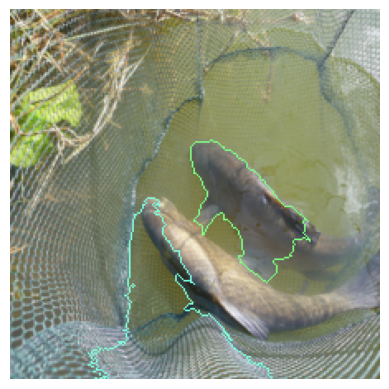

In [36]:
top_k = 5

# results = []
# for index in tqdm(indexes[:12+len(skip_imgs)]):    
# if index in skip_imgs: continue

# image_path = test_data[index]
# img_filename = image_path.split("/")[-1]
# image, labels = get_image_and_labels(image_path, device)

image = inputs[0].cpu().permute(1,2,0).numpy()
label = labels[0]
print('image', image.shape, 'label', label)

predictions = model_wrapper(np.expand_dims(image,0))
class_idx = predictions[0].argsort()[::-1][0]
print("classification:",backbone_config.id2label[class_idx])

baseline = np.zeros_like(image)
segments = quickshift(image, kernel_size=3, max_dist=300, ratio=0.2)

xf = ImageXformer(image, baseline, segments)
apgo = Archipelago(model_wrapper, data_xformer=xf, output_indices=class_idx, batch_size=20)
explanation = apgo.explain(top_k=top_k)
exp, num_pos_interactions = overlay_explanation(explanation, image, segments, outline_thickness = explanation_outline_thickness)


plt.imshow(exp/2+0.5)
plt.axis("off")
plt.show()
    
    # results.append( {"image":exp, "prediction": labels[class_idx]} )
    
#     with open('results/exp_figs_4-21_k5_nohuman_thin.pickle', 'wb') as handle:
#         pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [37]:
explanation

{(0,): 0.37437487,
 (1,): 1.3350079,
 (2,): 0.99852765,
 (3,): -0.1322177,
 (4,): 0.5469176,
 (5,): 0.99635136,
 (6,): 0.44479686,
 (7,): 0.33743656,
 (8,): 1.7380002,
 (9,): 0.27109212,
 (10,): 0.49735183,
 (11,): 0.4622714,
 (12,): 0.67859817,
 (13,): 0.8141774,
 (14,): 0.5532778,
 (15,): -0.65975547,
 (16,): 0.066872835,
 (17,): 0.6340055,
 (18,): -0.60172945,
 (19,): -0.78441536,
 (20,): 0.33208162,
 (21,): 0.25764495,
 (22,): -0.72566867,
 (23, 27): 9.236162,
 (24,): 1.407918,
 (25,): 0.18112752,
 (26,): 1.0716829,
 (28, 39, 40, 43, 46): 1.1676632,
 (29,): 0.4884895,
 (30,): 2.8662896,
 (31,): -0.42043114,
 (32,): 0.118908115,
 (33,): -0.3100133,
 (34,): -0.68268186,
 (35,): 4.570398,
 (36,): 1.4252031,
 (37,): 0.17908067,
 (38,): 0.084377006,
 (41,): 0.6036241,
 (42,): 1.9349573,
 (44,): 0.6511576,
 (45,): 0.7650326}

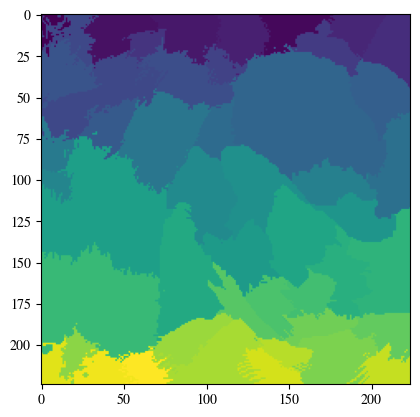

In [35]:
plt.imshow(segments)

In [38]:
segments.shape

(224, 224)

torch.Size([1, 224, 224])


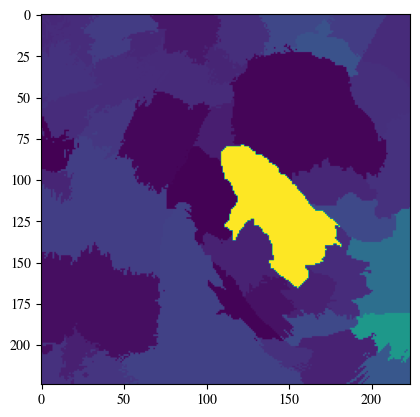

In [39]:
expln_scores = np.zeros_like(segments, dtype=float)
expln_flat_masks = np.zeros_like(segments, dtype=float)

for e_i, (k, v) in enumerate(explanation.items()):
    for s_i in k:
        expln_scores[segments == s_i] = v
        expln_flat_masks[segments == s_i] = e_i
plt.imshow(expln_scores)
expln_flat_masks = torch.tensor(expln_flat_masks).unsqueeze(0).to(device)
print(expln_flat_masks.shape)

In [40]:
expln_scores

array([[0.37437487, 0.37437487, 0.37437487, ..., 0.44479686, 0.44479686,
        0.44479686],
       [0.37437487, 0.49735183, 0.37437487, ..., 0.44479686, 0.44479686,
        0.44479686],
       [0.49735183, 0.37437487, 0.37437487, ..., 0.44479686, 0.44479686,
        0.44479686],
       ...,
       [0.65115762, 0.65115762, 0.65115762, ..., 1.93495727, 1.93495727,
        1.93495727],
       [0.65115762, 0.65115762, 0.65115762, ..., 1.93495727, 1.93495727,
        1.93495727],
       [0.65115762, 0.65115762, 0.65115762, ..., 1.93495727, 1.93495727,
        1.93495727]])

In [94]:
from collections import namedtuple


class WrappedBackboneModelRaw(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    
    def forward(self, inputs):
        outputs = self.model(inputs, output_hidden_states=True)
        return outputs.logits

In [95]:
wrapped_backbone_model_raw = WrappedBackboneModelRaw(backbone_model)

In [42]:
expln_scores_tensor = torch.tensor(expln_scores).unsqueeze(0)

del_evaluator_bbm = DeletionCls(wrapped_backbone_model_raw)
with torch.no_grad():
    del_score_archipelago = del_evaluator_bbm(inputs, expln_scores_tensor)
del_score_archipelago

 99%|█████████▉| 223/225 [00:02<00:00, 105.13it/s]


tensor([0.2200], device='cuda:0')

 99%|█████████▉| 223/225 [00:02<00:00, 96.29it/s] 


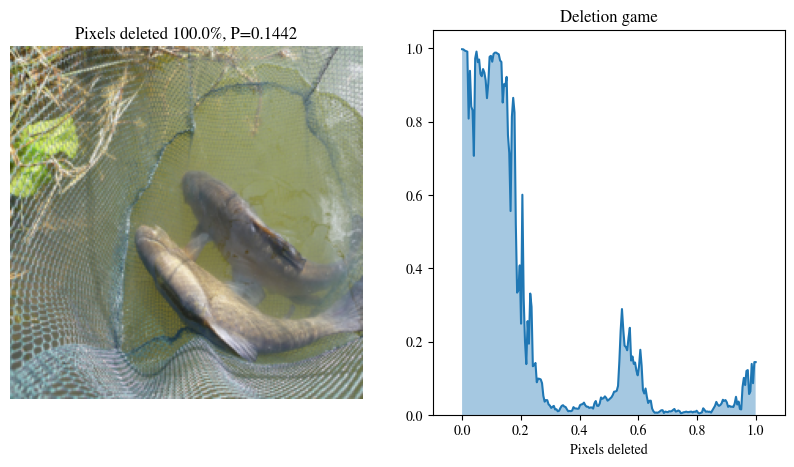

In [43]:
with torch.no_grad():
    del_eval_output_archipelago = del_evaluator_bbm(inputs, expln_scores_tensor, return_dict=True)
del_scores_archipelago = del_eval_output_archipelago['scores']
del_evaluator_bbm.plot(denormed_img[0], del_scores_archipelago[0])

 99%|█████████▉| 223/225 [00:01<00:00, 153.56it/s]


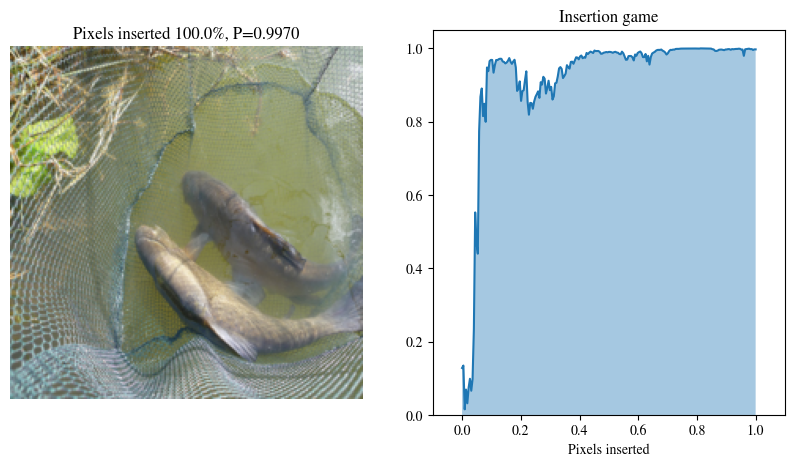

In [46]:
ins_evaluator_bbm = InsertionCls(wrapped_backbone_model_raw)
with torch.no_grad():
    ins_eval_output_archipelago = ins_evaluator_bbm(inputs, expln_scores_tensor, return_dict=True)
ins_scores_archipelago = ins_eval_output_archipelago['scores']
ins_evaluator_bbm.plot(denormed_img[0], ins_scores_archipelago[0])

In [59]:
ins_eval_output_archipelago['auc_score']

tensor([0.9209], device='cuda:0')

In [47]:
gdel_evaluator_archipelago = GroupedDeletionCls(wrapped_backbone_model_raw)
with torch.no_grad():
    gdel_score_archipelago = gdel_evaluator_archipelago(inputs, expln_scores_tensor, expln_flat_masks)
print(gdel_score_archipelago)

tensor([0.1250], device='cuda:0')


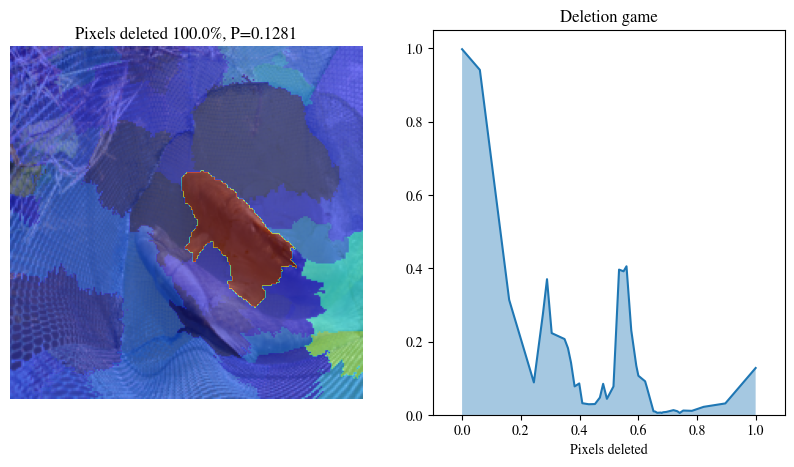

In [48]:
with torch.no_grad():
    gdel_eval_output_archipelago = gdel_evaluator_archipelago(inputs, expln_scores_tensor, expln_flat_masks, return_dict=True)
gdel_evaluator_archipelago.plot(denormed_img[0], expln_scores_tensor, 
                                gdel_eval_output_archipelago['scores'][0], 
                                gdel_eval_output_archipelago['step_sizes'][0])

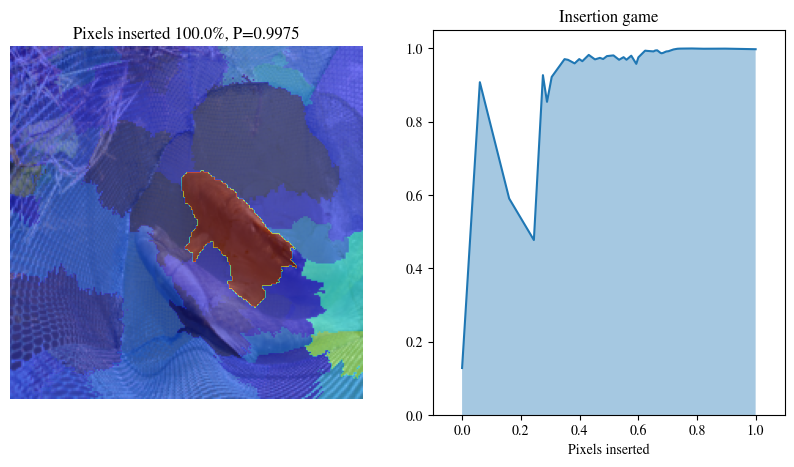

In [49]:
gins_evaluator_archipelago = GroupedInsertionCls(wrapped_backbone_model_raw)
with torch.no_grad():
    gins_eval_output_archipelago = gins_evaluator_archipelago(inputs, expln_scores_tensor, expln_flat_masks, return_dict=True)
gins_evaluator_archipelago.plot(denormed_img[0], expln_scores_tensor, 
                                gins_eval_output_archipelago['scores'][0], 
                                gins_eval_output_archipelago['step_sizes'][0])

# segments to patches

image (224, 224, 3) label tensor(0, device='cuda:0')
classification: tench, Tinca tinca


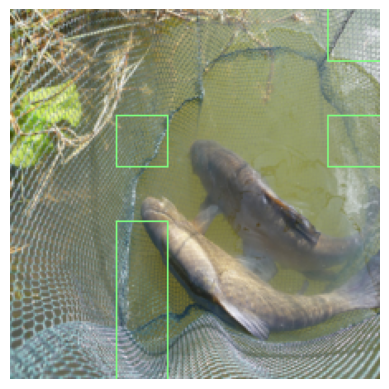

In [23]:
from exlib.explainers.common import patch_segmenter

top_k = 5

# results = []
# for index in tqdm(indexes[:12+len(skip_imgs)]):    
# if index in skip_imgs: continue

# image_path = test_data[index]
# img_filename = image_path.split("/")[-1]
# image, labels = get_image_and_labels(image_path, device)

image = inputs[0].cpu().permute(1,2,0).numpy()
label = labels[0]
print('image', image.shape, 'label', label)

predictions = model_wrapper(np.expand_dims(image,0))
class_idx = predictions[0].argsort()[::-1][0]
print("classification:",backbone_config.id2label[class_idx])

baseline = np.zeros_like(image)
# segments = quickshift(image, kernel_size=3, max_dist=300, ratio=0.2)
segments = patch_segmenter(image, sz=(7,7))

xf = ImageXformer(image, baseline, segments)
apgo = Archipelago(model_wrapper, data_xformer=xf, output_indices=class_idx, batch_size=20)
explanation = apgo.explain(top_k=top_k)
exp, num_pos_interactions = overlay_explanation(explanation, image, segments, outline_thickness = explanation_outline_thickness)


plt.imshow(exp/2+0.5)
plt.axis("off")
plt.show()
    
    # results.append( {"image":exp, "prediction": labels[class_idx]} )
    
#     with open('results/exp_figs_4-21_k5_nohuman_thin.pickle', 'wb') as handle:
#         pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)


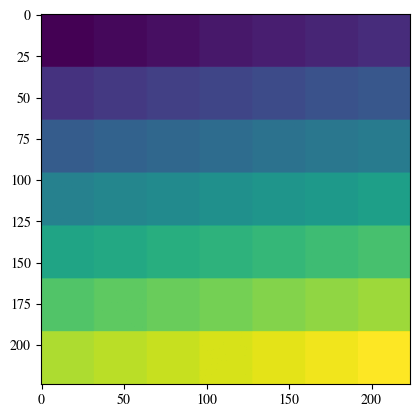

In [24]:
plt.imshow(segments)

torch.Size([1, 224, 224])


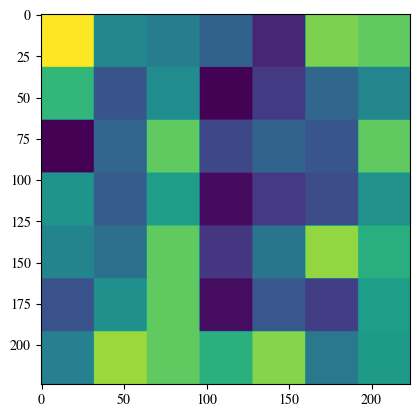

In [25]:
expln_scores = np.zeros_like(segments, dtype=float)
expln_flat_masks = np.zeros_like(segments, dtype=float)

for e_i, (k, v) in enumerate(explanation.items()):
    for s_i in k:
        expln_scores[segments == s_i] = v
        expln_flat_masks[segments == s_i] = e_i
plt.imshow(expln_scores)
expln_flat_masks = torch.tensor(expln_flat_masks).unsqueeze(0).to(device)
print(expln_flat_masks.shape)

 99%|█████████▉| 223/225 [00:01<00:00, 166.17it/s]


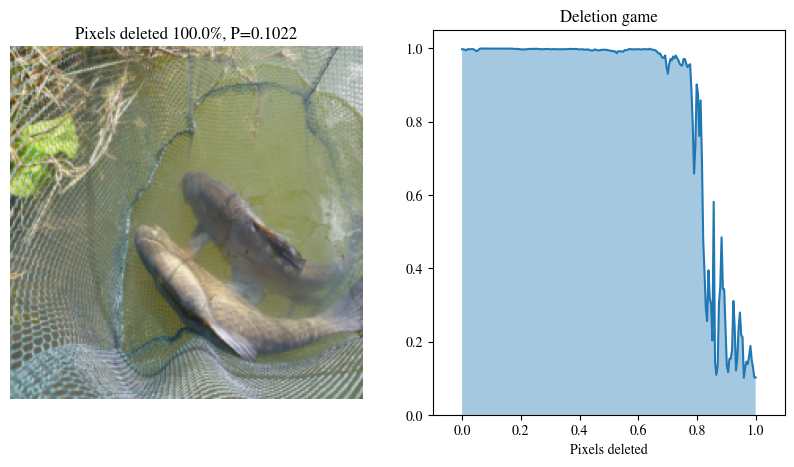

tensor([0.8474], device='cuda:0')


In [33]:
expln_scores_tensor = torch.tensor(expln_scores).unsqueeze(0)

del_evaluator_bbm = DeletionCls(wrapped_backbone_model_raw)
with torch.no_grad():
    del_eval_output_archipelago_patch = del_evaluator_bbm(inputs, expln_scores_tensor, return_dict=True)
del_scores_archipelago_patch = del_eval_output_archipelago_patch['scores']
del_evaluator_bbm.plot(denormed_img[0], del_scores_archipelago_patch[0])
print(del_eval_output_archipelago_patch['auc_score'])

 99%|█████████▉| 223/225 [00:01<00:00, 159.72it/s]


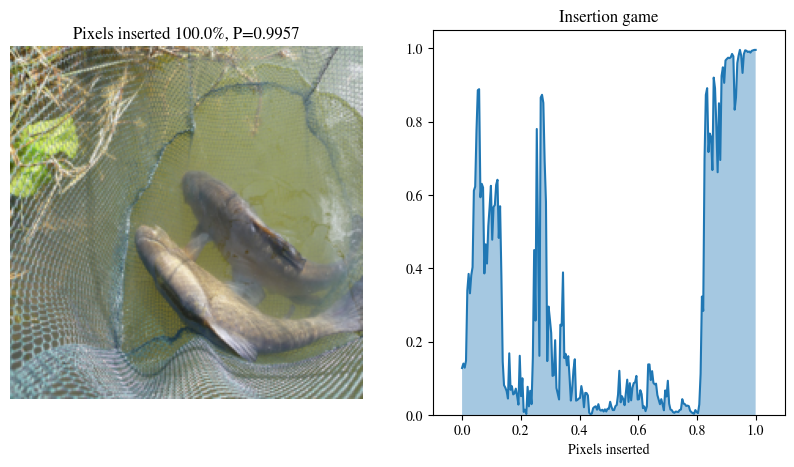

tensor([0.2974], device='cuda:0')


In [32]:
ins_evaluator_bbm = InsertionCls(wrapped_backbone_model_raw)
with torch.no_grad():
    ins_eval_output_archipelago_patch = ins_evaluator_bbm(inputs, expln_scores_tensor, return_dict=True)
ins_scores_archipelago_patch = ins_eval_output_archipelago_patch['scores']
ins_evaluator_bbm.plot(denormed_img[0], ins_scores_archipelago_patch[0])
print(ins_eval_output_archipelago_patch['auc_score'])

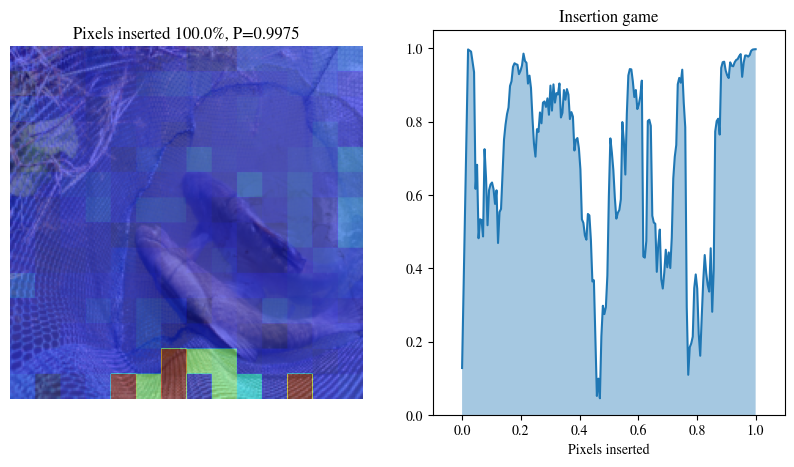

In [56]:
gins_evaluator_archipelago_patch = GroupedInsertionCls(wrapped_backbone_model_raw)
with torch.no_grad():
    gins_eval_output_archipelago_patch = gins_evaluator_archipelago_patch(inputs, expln_scores_tensor, expln_flat_masks, return_dict=True)
gins_evaluator_archipelago_patch.plot(denormed_img[0], expln_scores_tensor, 
                                gins_eval_output_archipelago_patch['scores'][0], 
                                gins_eval_output_archipelago_patch['step_sizes'][0])

In [57]:
gins_eval_output_archipelago_patch['auc_score']

tensor([0.3406], device='cuda:0')

image (224, 224, 3) label tensor(0, device='cuda:0')
classification: tench, Tinca tinca


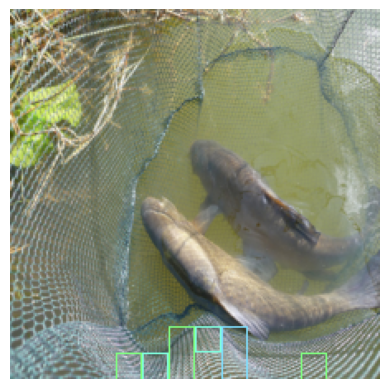

In [34]:
from exlib.explainers.common import patch_segmenter

top_k = 5

image = inputs[0].cpu().permute(1,2,0).numpy()
label = labels[0]
print('image', image.shape, 'label', label)

predictions = model_wrapper(np.expand_dims(image,0))
class_idx = predictions[0].argsort()[::-1][0]
print("classification:",backbone_config.id2label[class_idx])

baseline = np.zeros_like(image)
segments = patch_segmenter(image, sz=(14,14))

xf = ImageXformer(image, baseline, segments)
apgo = Archipelago(model_wrapper, data_xformer=xf, output_indices=class_idx, batch_size=20)
explanation = apgo.explain(top_k=top_k)
exp, num_pos_interactions = overlay_explanation(explanation, image, segments, outline_thickness = explanation_outline_thickness)


plt.imshow(exp/2+0.5)
plt.axis("off")
plt.show()

 99%|█████████▉| 223/225 [00:01<00:00, 167.35it/s]


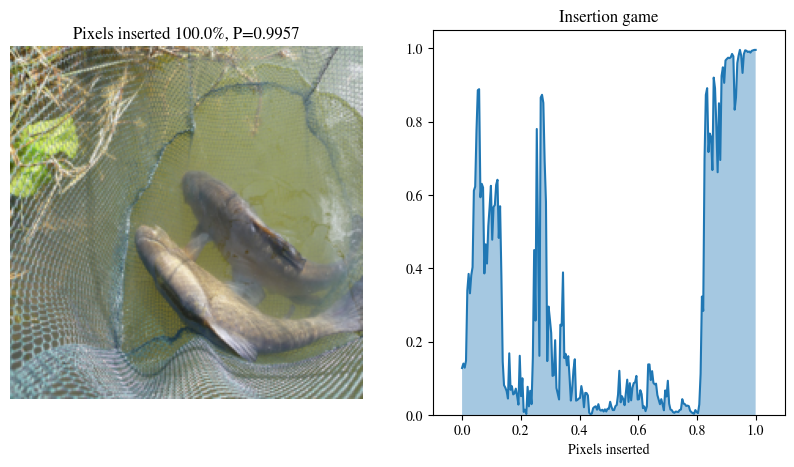

tensor([0.2974], device='cuda:0')


In [36]:
expln_scores_tensor = torch.tensor(expln_scores).unsqueeze(0)
with torch.no_grad():
    ins_eval_output_archipelago_patch = ins_evaluator_bbm(inputs, expln_scores_tensor, return_dict=True)
ins_scores_archipelago_patch = ins_eval_output_archipelago_patch['scores']
ins_evaluator_bbm.plot(denormed_img[0], ins_scores_archipelago_patch[0])
print(ins_eval_output_archipelago_patch['auc_score'])